## Black-Scholes-Merton model ##
### Предположения модели ###
В моделе Блэка-Шульца предполагается, что на рынке есть безрисковый актив (Bond) и как минимум один актив с риском (Stock). (B, S)-рынок.

Предположения о рынке:

* **No arbitrage** (не существует стратегии, которая бы давала прибыль без риска принести убытки).
* Можно занимать поцию с **любым номиналом** по все доступным активам. Включаю отрицательные (long / short selling, borrow / lend) и дробные номиналы.
* **Frictionless market**. Принебрегаем стоимостью транзаций и Bid/Ask spread.


Активы ( B, S ):

* Risk-free rate: **r = const**.
* Движение рыночной цены S - **геометрическое броуновское движение** с постоянными параметрами drift и volatility.

* В классическом варианте по underlying активу нет начисления дивидентов. Но модель легко обобщается на случай актива с дивидентами. Это необходимо для, например, для FX options.


### Уровнение для цены опциона ###

$$ \frac{\partial C}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 C}{\partial S^2} + rS\frac{\partial C}{\partial S} - rC = 0 $$
PDE, not SDE (!) 


### Формула  ( $q \ne 0$)###
Формула Блэка-Шульца для Европейского call-опциона:  

$$ C(S, K, \tau, r, q, \sigma) = N( d_+ ) S e^{ -q \tau} - N( d_- ) K e^{ -r \tau } $$  

для put-опциона:

$$ P(S, K, \tau, r, q, \sigma) = K e^{-r \tau } N( -d_{-} ) - S e^{ - q \tau } N( -d_{+} ) $$

где: 
$$ \tau = T - t $$
.

$$  d_{+} = \frac{ \log{ \frac{S}{K} } + (r-q + \frac{ \sigma^{2} }{2} ) \tau }{ \sigma \sqrt{ \tau }  } = d_{1}  $$    
и  

$$  d_{-} = d_{+} - \sigma  \sqrt{ \tau } = \frac{ \log{ \frac{S}{K} } + (r-q - \frac{ \sigma^{2} }{2}  ) \tau}{ \sigma \sqrt{ \tau } } = d_{2} $$  

$N(z) = \Phi(z) = \frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{z} e^{-\frac{ x^{2}}{2} } dx$ это функция распределения для стандартного нормального (гаусовского) распределения. 

Плотность распределения: $N'(z) = \phi(z) = \frac{1}{\sqrt{2 \pi}} e^{-\frac{ z^{2}}{2}}$.



In [1]:
import numpy as np
import scipy as sp
from scipy import stats
import math as m

import matplotlib.pyplot as plt
%matplotlib inline


In [12]:
def N(x):
    return stats.norm.cdf(x, 0.0, 1.0)

def NPrime(x):
    return stats.norm.pdf(x, 0.0, 1.0)

def bsm_d1(S, K, T, r, q, sigma):
    return (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * m.sqrt(T))

def bsm_d2(S, K, T, r, q, sigma):
    return (np.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * m.sqrt(T))

def bsm_pv(isCall, S, K, T, r, q, sigma):
    d1 = bsm_d1(S, K, T, r, q, sigma)
    d2 = bsm_d2(S, K, T, r, q, sigma)
    if isCall:
        return S * N(d1) * m.exp(-q * T) - K * m.exp(-r * T) * N(d2)
    else:
        return K * N(-d2) * m.exp(-r * T)  - S * m.exp(-q * T) * N(-d1)

def bsm_delta(isCall, S, K, T, r, q, sigma):
    d1 = bsm_d1(S, K, T, r, q, sigma)
    if isCall:
        return N(d1) * m.exp(-q * T)
    else:
        return -N(-d1) * m.exp(-q * T)
    
def bsm_gamma(isCall, S, K, T, r, q, sigma):
    d1 = bsm_d1(S, K, T, r, q, sigma)
    return NPrime(d1) * m.exp(-q * T) / (S * sigma * m.sqrt(T))
    
def bsm_vega(isCall, S, K, T, r, q, sigma):
    d1 = bsm_d1(S, K, T, r, q, sigma)
    return S * NPrime(d1) * m.sqrt(T)

def bsm_theta(isCall, S, K, T, r, q, sigma):
    d1 = bsm_d1(S, K, T, r, q, sigma)
    d2 = bsm_d2(S, K, T, r, q, sigma)
    x = - m.exp(-q * T) * S * NPrime(d1) * sigma / ( 2 * m.sqrt(T) )
    y = r * K * m.exp( -r * T )
    z = q * S * m.exp( -q * T )
    if isCall:
        return x - y*N(d2) + z*N(d1)
    else:
        return x + y*N(-d2) - z*N(-d1)
    

In [3]:
 def call_payoff(K, S):
    return np.maximum(S-K, 0)

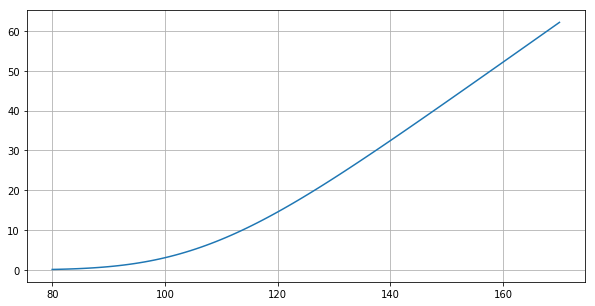

In [37]:
K = 110
r = 0.02
sigma = 0.15
x = np.linspace(K-30, K+60, num=100)
#
f, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.plot(x, bsm_pv(True, S=x, K=K, T=1, r=r, q=0, sigma=sigma ))

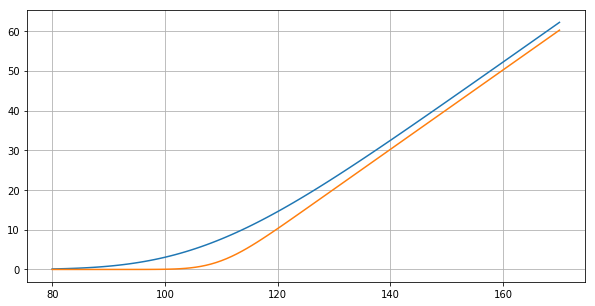

In [38]:
ax.plot(x, bsm_pv(True, S=x, K=K, T=0.1, r=r, q=0, sigma=sigma ))
f

-----
## PV and Delta 
### $T \rightarrow 0$ 

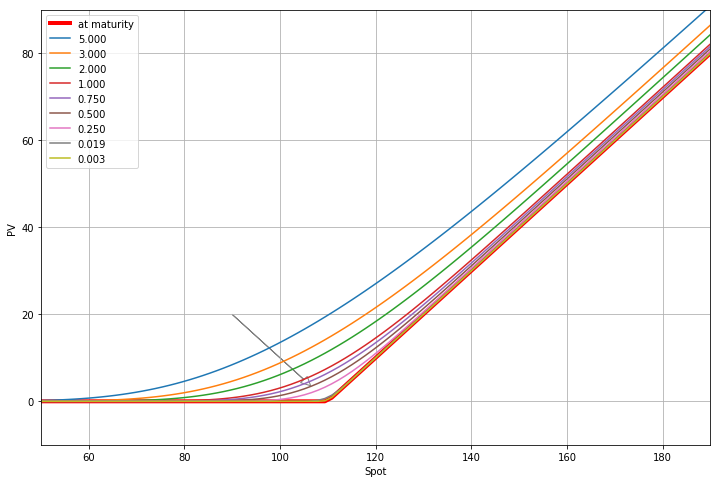

In [39]:
Ts = [5, 3, 2, 1, 0.75, 0.5, 0.25, 1./52., 1./365.]

x = np.linspace(50, K+80, num=100)
f, ax = plt.subplots(figsize=(12,8))
ax.grid(True)
plt.plot(x, call_payoff(K, x), 'r', linewidth=4)
for T in Ts:
    ax.plot(x, bsm_pv(True, S=x, K=K, T=T, r=r, q=0, sigma=sigma ))
plt.legend(['at maturity'] + ['{:.3f}'.format(t) for t in Ts], loc = "upper left")
axes = plt.gca()
axes.set_xlim([min(x),max(x)]); axes.set_ylim([-10,90]);
axes.set_xlabel('Spot'); axes.set_ylabel('PV');
axes.arrow(90, 20, 15, -15, head_width=2, head_length=2, fc='white', ec='grey')

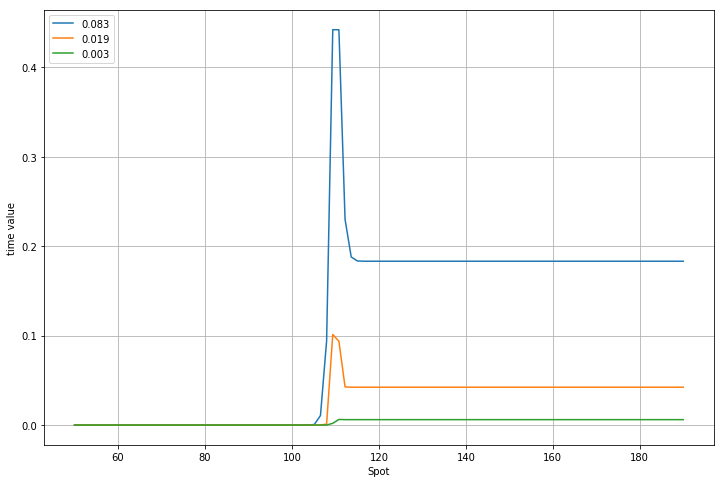

In [70]:
Ts = [1/12., 1./52., 1./365.]

x = np.linspace(50, K+80, num=100)
f, ax = plt.subplots(figsize=(12,8))
ax.grid(True)
for T in Ts:
    ax.plot(x, bsm_pv(True, S=x, K=K, T=T, r=r, q=0, sigma=sigma ) - call_payoff(K, x) )
plt.legend(['{:.3f}'.format(t) for t in Ts], loc = "upper left")
axes = plt.gca()
#axes.set_xlim([min(x),max(x)]); axes.set_ylim([-10,90]);
axes.set_xlabel('Spot'); axes.set_ylabel('time value');
#axes.arrow(90, 20, 15, -15, head_width=2, head_length=2, fc='white', ec='grey')

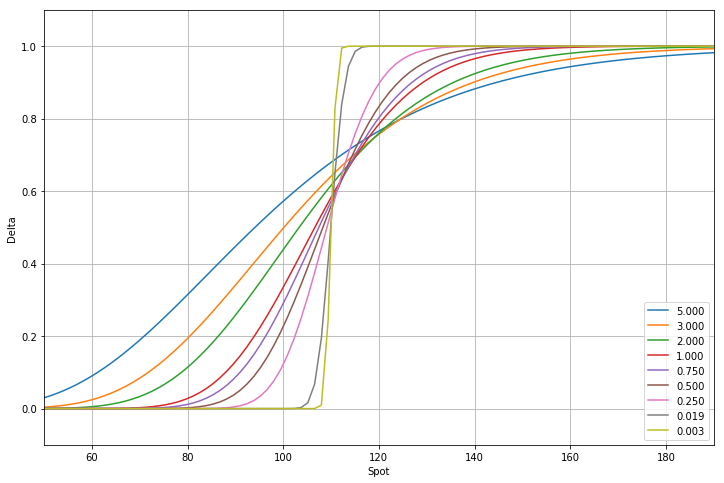

In [42]:
Ts = [5, 3, 2, 1, 0.75, 0.5, 0.25, 1./52., 1./365.]

x = np.linspace(50, K+80, num=100)
f, ax = plt.subplots(figsize=(12,8))
ax.grid(True)
for T in Ts:
    ax.plot(x, bsm_delta(True, S=x, K=K, T=T, r=r, q=0, sigma=sigma ))
plt.legend(['{:.3f}'.format(t) for t in Ts], loc = "lower right")
axes = plt.gca()
axes.set_xlim([min(x),max(x)]); axes.set_ylim([-0.1,1.1]);
axes.set_xlabel('Spot'); axes.set_ylabel('Delta');

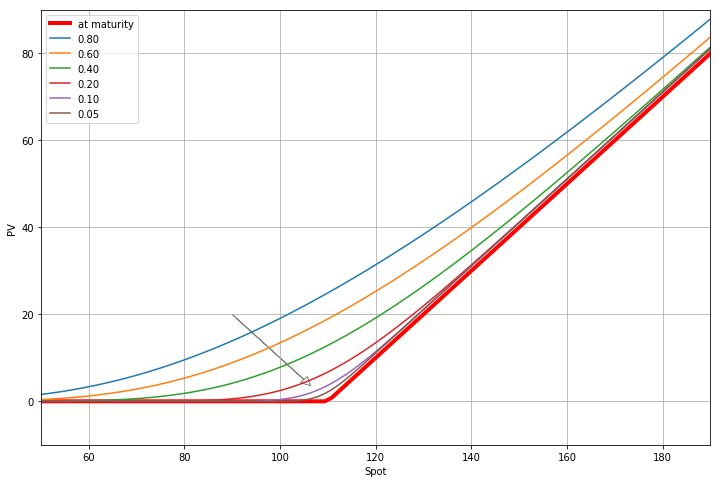

In [43]:
T = 0.5
sigmas = [0.8, 0.6, 0.4, 0.2, 0.1, 0.05]

x = np.linspace(50, K+80, num=100)
f, ax = plt.subplots(figsize=(12,8))
ax.grid(True)
plt.plot(x, call_payoff(K, x), 'r', linewidth=4)
for sigma in sigmas:
    ax.plot(x, bsm_pv(True, S=x, K=K, T=T, r=r, q=0, sigma=sigma ))
plt.legend(['at maturity'] + ['{:.2f}'.format(s) for s in sigmas], loc = "upper left")
axes = plt.gca()
axes.set_xlim([min(x),max(x)]); axes.set_ylim([-10,90]);
axes.set_xlabel('Spot'); axes.set_ylabel('PV');
axes.arrow(90, 20, 15, -15, head_width=2, head_length=2, fc='white', ec='grey')

### $\sigma \rightarrow 0$ 

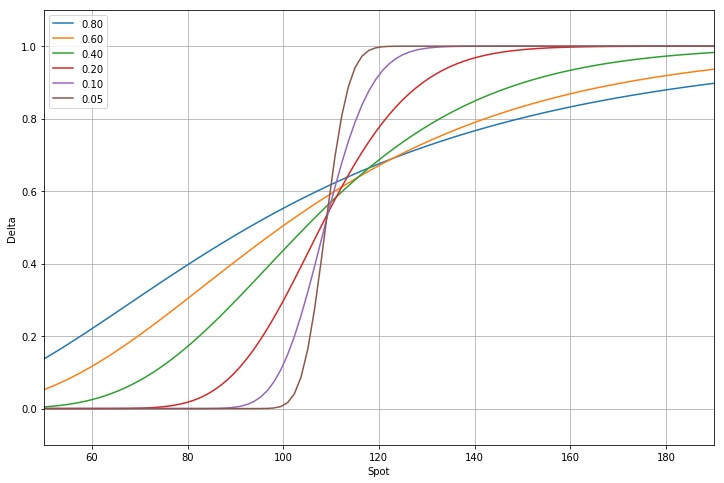

In [44]:
T = 0.5
sigmas = [0.8, 0.6, 0.4, 0.2, 0.1, 0.05]

x = np.linspace(50, K+80, num=100)
f, ax = plt.subplots(figsize=(12,8))
ax.grid(True)
#plt.plot(x, call_payoff(K, x), 'r', linewidth=4)
for sigma in sigmas:
    ax.plot(x, bsm_delta(True, S=x, K=K, T=T, r=r, q=0, sigma=sigma ))
plt.legend(['{:.2f}'.format(s) for s in sigmas], loc = "upper left")
axes = plt.gca()
axes.set_xlim([min(x),max(x)]); axes.set_ylim([-0.1,1.1]);
axes.set_xlabel('Spot'); axes.set_ylabel('Delta');

## Gamma

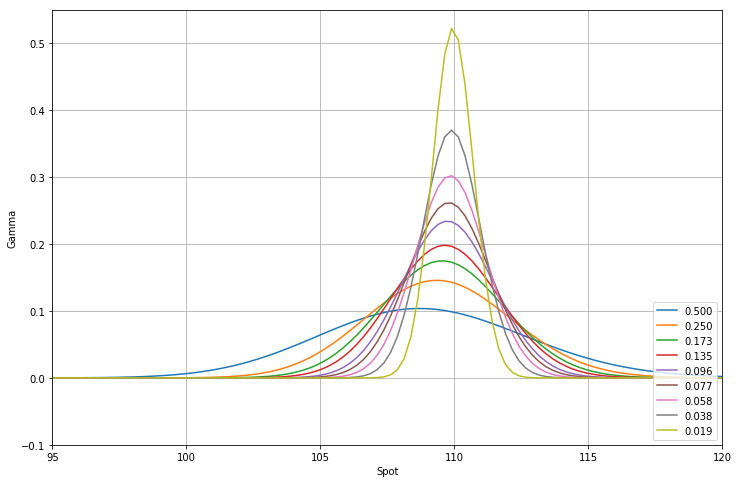

In [45]:
#r = 0.02
Ts = [0.5, 0.25, 9./52., 7./52., 5./52., 4./52., 3./52., 2./52., 1./52.] #, 1./365.]

x = np.linspace(95, K+10, num=100)
f, ax = plt.subplots(figsize=(12,8))
ax.grid(True)
for T in Ts:
    ax.plot(x, bsm_gamma(True, S=x, K=K, T=T, r=r, q=0, sigma=sigma ))
plt.legend(['{:.3f}'.format(t) for t in Ts], loc = "lower right")
axes = plt.gca()
axes.set_xlim([min(x),max(x)]); axes.set_ylim([-0.1,0.55]);
axes.set_xlabel('Spot'); axes.set_ylabel('Gamma');

### Vega

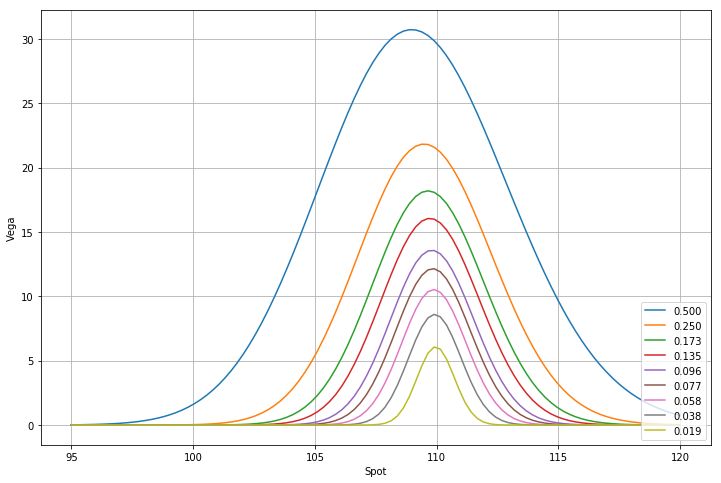

In [46]:
Ts = [0.5, 0.25, 9./52., 7./52., 5./52., 4./52., 3./52., 2./52., 1./52.] #, 1./365.]


x = np.linspace(95, 120, num=100)
f, ax = plt.subplots(figsize=(12,8))
ax.grid(True)
for T in Ts:
    ax.plot(x, bsm_vega(True, S=x, K=K, T=T, r=r, q=0, sigma=sigma ))
plt.legend(['{:.3f}'.format(t) for t in Ts], loc = "lower right")
axes = plt.gca()
#axes.set_xlim([min(x),max(x)]); axes.set_ylim([-0.1,1.1]);
axes.set_xlabel('Spot'); axes.set_ylabel('Vega');

### Theta

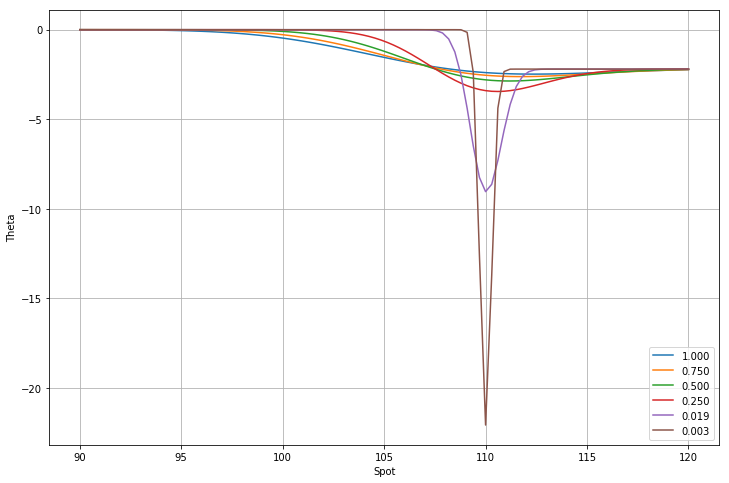

In [47]:
Ts = [1, 0.75, 0.5, 0.25, 1./52., 1./365.]

x = np.linspace(90, 120, num=100)
f, ax = plt.subplots(figsize=(12,8))
ax.grid(True)
for T in Ts:
    ax.plot(x, bsm_theta(True, S=x, K=K, T=T, r=r, q=0, sigma=sigma ))
plt.legend(['{:.3f}'.format(t) for t in Ts], loc = "lower right")
axes = plt.gca()
#axes.set_xlim([min(x),max(x)]); axes.set_ylim([-0.1,1.1]);
axes.set_xlabel('Spot'); axes.set_ylabel('Theta');

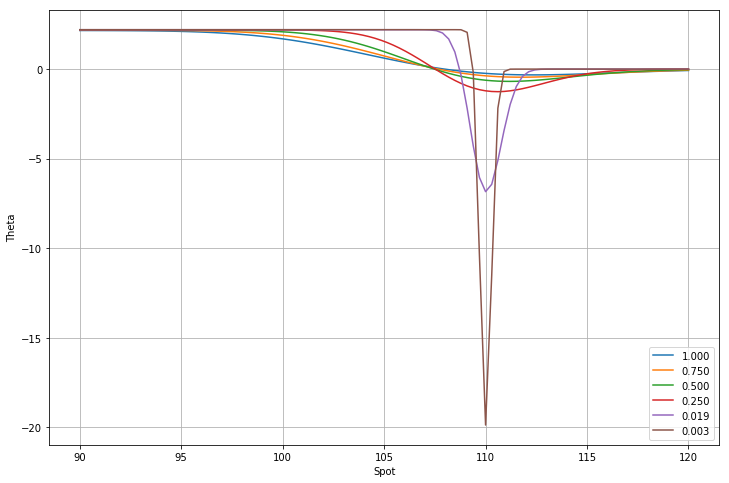

In [48]:
Ts = [1, 0.75, 0.5, 0.25, 1./52., 1./365.]

x = np.linspace(90, 120, num=100)
f, ax = plt.subplots(figsize=(12,8))
ax.grid(True)
for T in Ts:
    ax.plot(x, bsm_theta(False, S=x, K=K, T=T, r=r, q=0, sigma=sigma ))
plt.legend(['{:.3f}'.format(t) for t in Ts], loc = "lower right")
axes = plt.gca()
#axes.set_xlim([min(x),max(x)]); axes.set_ylim([-0.1,1.1]);
axes.set_xlabel('Spot'); axes.set_ylabel('Theta');